# Test pipeline of the project

## Dataset

In [1]:
import os
from src.utils.data_loading_functions import *

In [2]:
label_path="data/MLinApp_course_data/tcga_mir_label.csv"
data_path="data/MLinApp_course_data/tcga_mir_rpm.csv"

miRna_labels, miRna_data, miRna_tissues = load_data(data_path, label_path)

### Preprocessing data: class balancing, normalization and split.

In [3]:
miRna_data, miRna_labels , _, _, _, _ = class_balancing(miRna_labels, miRna_data, miRna_tissues)

miRna_data = normalize_data(miRna_data)

train_data, test_data, train_label, test_label = split_data(miRna_data, miRna_labels)

Adjusting dataset...
Removed classes: 'COAD' 'LAML' 'OV' 'GBM'!


Balancing BRCA data...
BRCA data balanced!


Processing labels...
Done!
['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'DLBC' 'ESCA' 'HNSC' 'KICH' 'KIRC'
 'KIRP' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'PAAD' 'PCPG' 'PRAD' 'READ'
 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC' 'UCS' 'UVM']
['Adrenal gland' 'Base of tongue' 'Bladder'
 'Bones, joints and articular cartilage of limbs'
 'Bones, joints and articular cartilage of other and unspecified sites'
 'Brain' 'Breast' 'Bronchus and lung' 'Cervix uteri' 'Colon'
 'Connective, subcutaneous and other soft tissues' 'Corpus uteri'
 'Esophagus' 'Eye and adnexa' 'Floor of mouth' 'Gallbladder' 'Gum'
 'Heart, mediastinum, and pleura' 'Hypopharynx' 'Kidney' 'Larynx' 'Lip'
 'Liver and intrahepatic bile ducts' 'Lymph nodes' 'Meninges' 'Oropharynx'
 'Other and ill-defined sites'
 'Other and ill-defined sites in lip, oral cavity and pharynx'
 'Other and unspecified major salivary glands'
 'Other and

We are gonna use only the test data because we don't need to train.

## Intelligent Reasoning

In [4]:
from src.utils.metadata_functions import *
from src.utils.utils import *
from src.utils.statistics import *

These superclasses are selected in the training phase of the representation procesess

In [5]:
superclasses = { '0' :
    ['BRCA', 'KICH', 'KIRC', 'LUAD', 'LUSC', 'MESO', 'SARC', 'UCEC'], '1' :
    ['BLCA', 'CESC', 'HNSC', 'KIRP', 'PAAD', 'READ', 'STAD'], '2' :
    ['DLBC', 'LGG', 'PRAD', 'TGCT', 'THYM', 'UCS'], '3' :
    ['ACC', 'CHOL', 'LIHC'], '4' :
    ['ESCA', 'PCPG', 'SKCM', 'THCA', 'UVM']
}

### Metadata creation and classification

In [6]:
test_superlabel = lab2super(test_label, superclasses)

In [7]:
ovo, ovr = load_ovo_ovr('_trained_1')

d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator OneVsOneClassifier from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\ba

Creation of test metadata

In [8]:
meta_data = meta_data_creation_test(ovo, ovr, test_data, test_superlabel)

Starting test set metadata creation...

Metadata for the whole dataset created!


In [9]:
meta_data.shape

(1865, 15)

In [10]:
rf = load_model('src/models/metadata/', 'rf_trained_1')

d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
prediction = rf.predict(meta_data)

array([[0.88, 0.06, 0.03, 0.03, 0.01],
       [0.04, 0.91, 0.03, 0.02, 0.  ],
       [0.  , 0.04, 0.95, 0.  , 0.  ],
       [0.09, 0.03, 0.01, 0.83, 0.04],
       [0.01, 0.02, 0.01, 0.07, 0.89]])

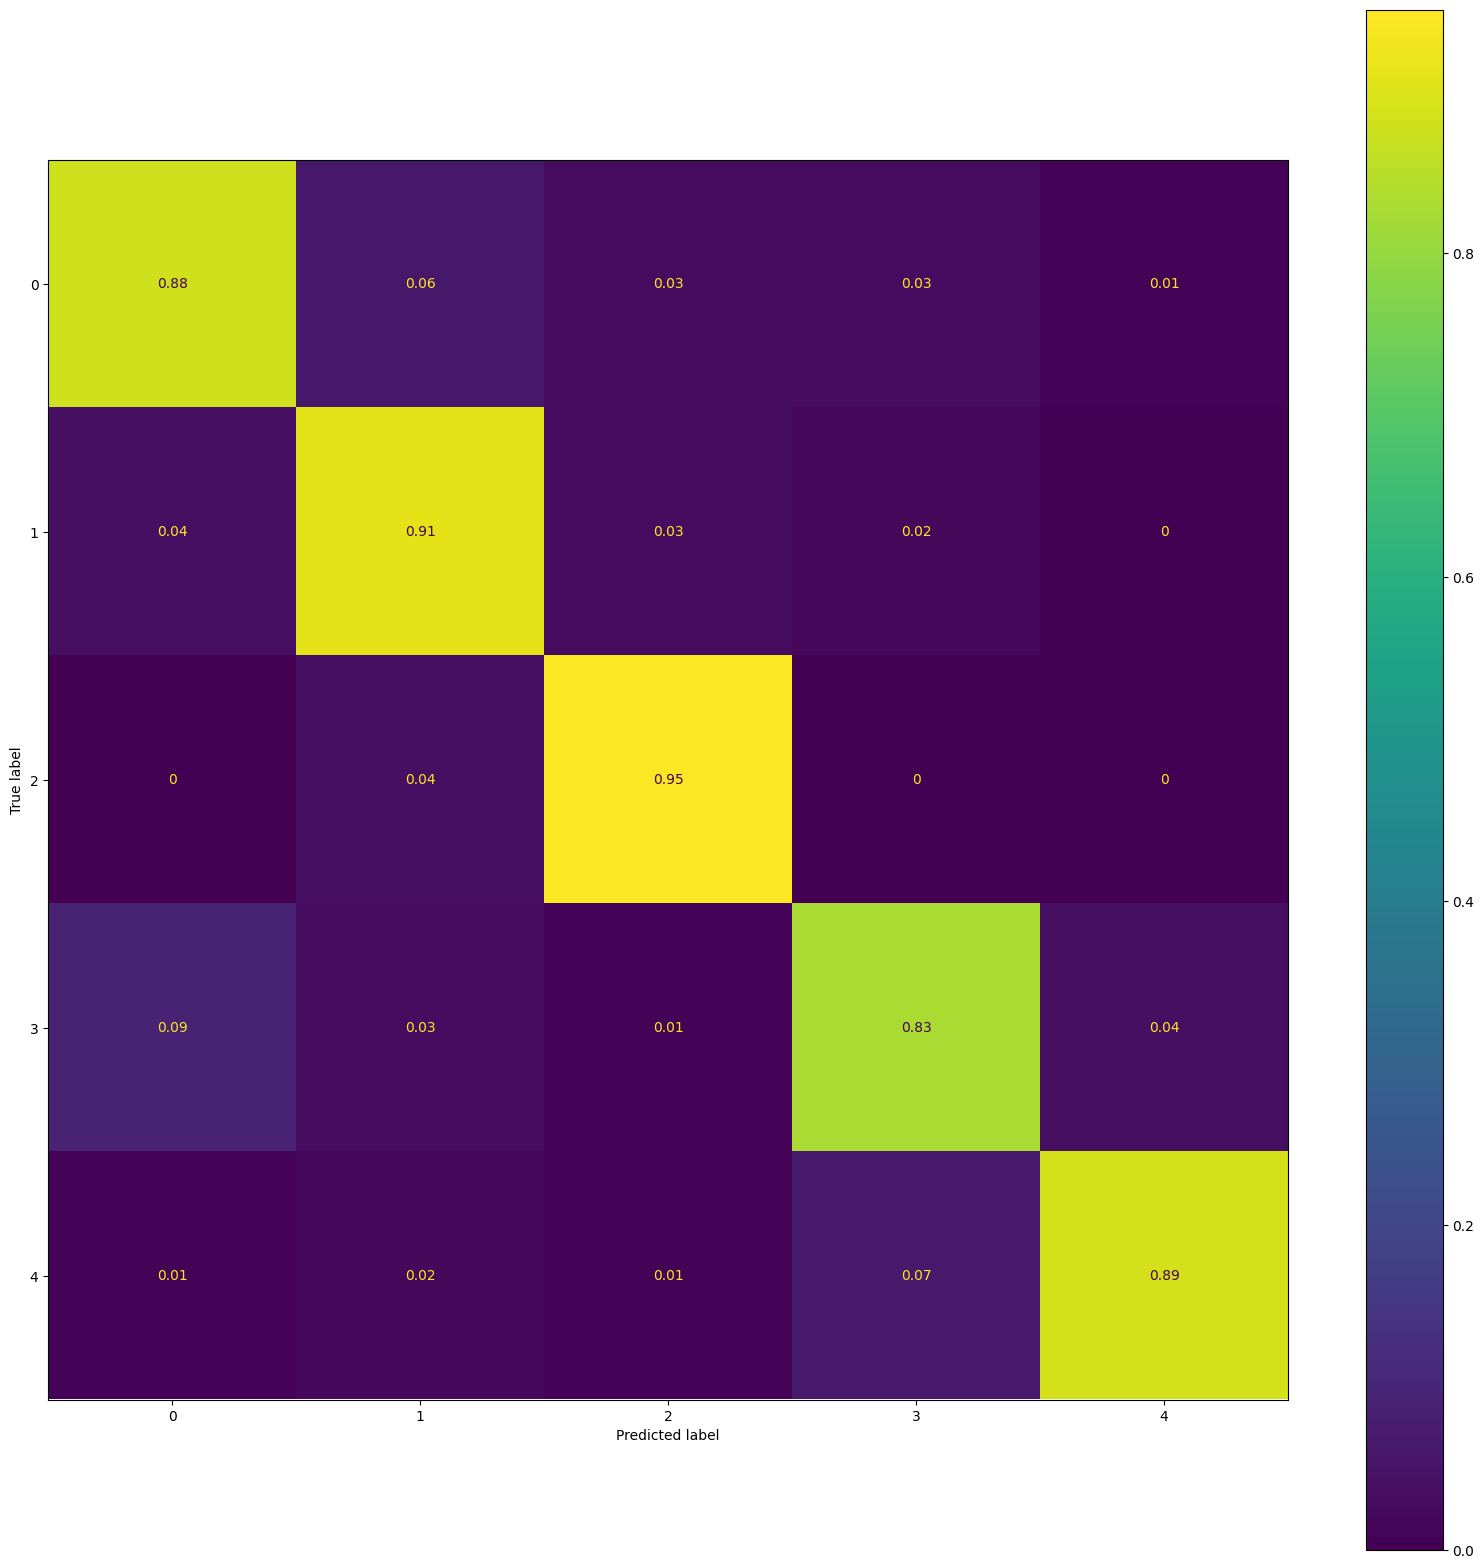

In [12]:
show_matrix(test_superlabel, prediction, superclasses.keys())


In [13]:
# Get some statistics
from sklearn.metrics import classification_report
print(classification_report(test_superlabel, prediction))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       674
           1       0.88      0.91      0.89       491
           2       0.88      0.95      0.91       282
           3       0.68      0.83      0.75       121
           4       0.96      0.89      0.92       297

    accuracy                           0.90      1865
   macro avg       0.87      0.89      0.88      1865
weighted avg       0.90      0.90      0.90      1865



## CNN and SCNN classification

In [14]:
# TODO: add all the test pipeline of the CNN and SCNN classification.
from src.utils.dataloader import load_dataset
from src.models.CNN import CNN
from src.models.SCNN import SCNN

import torch
import torch.nn as nn
import torch.optim as optim

import os
import json

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print(device)
# device = 'cpu'

cpu


In [15]:
superclasses = [
    ['BRCA', 'KICH', 'KIRC', 'LUAD', 'LUSC', 'MESO', 'SARC', 'UCEC'],
    ['BLCA', 'CESC', 'HNSC', 'KIRP', 'PAAD', 'READ', 'STAD'],
    ['DLBC', 'LGG', 'PRAD', 'TGCT', 'THYM', 'UCS'],
    ['ACC', 'CHOL', 'LIHC'],
    ['ESCA', 'PCPG', 'SKCM', 'THCA', 'UVM']
]

### Utility Functions

In [44]:
import snntorch as snn


def load_params(typeof='cnn', num_class=0):
    '''
    Load the parameters of the model.

    Args:
        typeof (str): type of the model, cnn or scnn.
        num_class (int): number of classes.

    Returns:
        params (dict): dictionary with the parameters of the model.
    '''
    assert typeof.startswith(('cnn', 'scnn')), 'Type of model not supported'
    params_path = os.path.join('data', 'params', typeof, f'{typeof}_class{num_class}.json')

    return json.loads(open(params_path).read())

def set_model(model_name: str, num_classes: int, params: dict):
    '''
    Set the model with its parameters, given the name of the model, the class number and the parameters.

    Args:
        model_name (str): name of the model.
        num_class (int): class index.
        params (dict): dictionary with the parameters of the model.
    
    Returns:
        model (nn.Module): model with the parameters set.
    '''
    filter_numbers = [params['nf1'], params['nf2'], params['nf3']]
    convolution_windows = [params['cw1'], params['cw2'], params['cw3']]
    max_pooling_windows = [params['pw1'], params['pw2'], params['pw3']]
    if model_name.startswith('cnn'):
        dropout = [params['dropout_0'], params['dropout_1']]
    else:
        beta = params['beta']
    final_nf = params['nf4']
    
    if model_name.startswith('cnn'):
        model = CNN(num_classes, filter_numbers, convolution_windows, max_pooling_windows, final_nf, dropout)
    else:
        model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=filter_numbers[0], kernel_size=convolution_windows[0]),
        nn.MaxPool1d(kernel_size=max_pooling_windows[0]),
        snn.Leaky(beta=beta, spike_grad=snn.surrogate.fast_sigmoid(), init_hidden=True, learn_beta=True),
        nn.Conv1d(in_channels=filter_numbers[0], out_channels=filter_numbers[1], kernel_size=convolution_windows[1]),
        nn.MaxPool1d(kernel_size=max_pooling_windows[1]),
        snn.Leaky(beta=beta, spike_grad=snn.surrogate.fast_sigmoid(), init_hidden=True, learn_beta=True),
        nn.Conv1d(in_channels=filter_numbers[1], out_channels=filter_numbers[2], kernel_size=convolution_windows[2]),
        nn.MaxPool1d(kernel_size=max_pooling_windows[2]),
        snn.Leaky(beta=beta, spike_grad=snn.surrogate.fast_sigmoid(), init_hidden=True, learn_beta=True),
        nn.Flatten(),
        nn.LazyLinear(final_nf),
        nn.Linear(final_nf, num_classes),
        snn.Leaky(beta=beta, spike_grad=snn.surrogate.fast_sigmoid(), init_hidden=True, output=True, learn_beta=True)
    )
    model.to(device)
    return model


In [47]:
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

def dummy_train(data, model, loss_fn, optimizer):
    # dummy train to initialize the model
    model.train()
    # data it's a sample of the dataset
    X, y = data
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct

def test_accuracy(data_loader, net, population_code=False, num_classes=False):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      data = data.to(device)
      targets = targets.to(device)
      utils.reset(net)
      spk_rec, _ = net(data)

      if population_code:
        acc += SF.accuracy_rate(spk_rec.unsqueeze(0), targets, population_code=True, num_classes=num_classes) * spk_rec.size(1)
      else:
        acc += SF.accuracy_rate(spk_rec.unsqueeze(0), targets) * spk_rec.size(1)
        
      total += spk_rec.size(1)

  return acc/total

def experiment(model_name: str, params: dict, metalabel: int, labels_of_metaclass, epochs:int, mode: str = 'train'):
    num_classes = len(labels_of_metaclass)

    print(f'METACLASS LABELS: {labels_of_metaclass}')
    train_dataloader, test_dataloader = load_dataset(name='cancer', batch_size=params['batch_size'],
                                                     metalabel=metalabel, labels_of_metaclass=labels_of_metaclass)

    if mode == 'train':
        model = set_model(model_name, num_classes, params)
    else:
        model = load_model(os.path.join('models', model_name), model_name, metalabel, params)
    epochs = epochs  # TODO: be careful
    
    
    loss_fn = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0) if model_name.startswith('scnn') else nn.CrossEntropyLoss()
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    num_steps = params['num_step']

    for t in range(epochs):
        if t % 10 == 0:
            print(f"Epoch {t + 1}\n-------------------------------")
        if mode == 'train':
            if model_name.startswith('cnn'):
                train(train_dataloader, model, loss_fn, optimizer)
            else:
                 backprop.BPTT(model, train_dataloader, num_steps=num_steps,
                            optimizer=optimizer, criterion=loss_fn, time_var=False, device=device)

        if t % 10 == 0:
            if model_name.startswith('cnn'):
                accuracy = test(test_dataloader, model, loss_fn)
            else:
                accuracy = test_accuracy(test_dataloader, model, num_steps=num_steps)
            print(accuracy)
    print("Done!")
    print(f"Accuracy for superclass {metalabel}: {accuracy}")

    
    # input('Premi un tasto per concludere l esperimento...')
    # Sorre: Ho modificato il path per salvare i modelli all'interno della cartella models e non data/models
    save_filepath = os.path.join('models', model_name)
    if not os.path.exists(save_filepath):
        os.makedirs(save_filepath)

    if mode == 'train':    
        torch.save(model.state_dict(), os.path.join(save_filepath, f'{model_name}_class{metalabel}.pth'))

    # Call the save_model function to save the model



In [68]:
def load_model(model_path: str, typeof: str, metaclass: int, num_classes: int, params: dict, data = None):
    '''
    Load the model given the path, the type and the class number.

    Args:
        model_path (str): path of the model.
        typeof (str): type of the model.
        num_class (int): class index.

    Returns:
        model (nn.Module): model loaded.
    '''
    assert typeof.startswith(('cnn', 'scnn')), 'Type of model not supported'
    filepath = os.path.join(model_path, f'{typeof}_class{metaclass}.pth')
    model = set_model(typeof, num_classes, params)
    # use one iteration of data to initialize the model:
    #for a in data:
    #    dummy_train(a, model, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=params['lr']))
    #    break

    

    model.load_state_dict(torch.load(filepath))
    return model

### Example of re-training the S-CNN with the selected model parameters

In [21]:
model_name = 'cnn'
epochs = 100

In [ ]:

for metalabel in range(5):
    params = load_params(model_name, metalabel)
    metaclass_labels = superclasses[metalabel]
    experiment(
        model_name=model_name,
        params=params,
        metalabel= metalabel,
        labels_of_metaclass=metaclass_labels,
        epochs=epochs
    )

### Test the CNN models

In [18]:
from src.utils.feature_selection import FeatureSelection

fs = FeatureSelection('filter_features.csv', superclasses)

In [19]:
selected_features = fs.load_features()
selected_features

,Unnamed: 0,Super-class0,Super-class1,Super-class2,Super-class3,Super-class4
0,0,1880,248,189,248,601
1,1,89,25,26,252,356
2,2,249,252,263,49,287
3,3,5,1874,264,251,194
4,4,271,251,106,1838,89
...,...,...,...,...,...,...
295,295,1519,1570,991,99,298
296,296,1560,1737,930,1709,1546
297,297,830,147,639,1041,1866
298,298,1402,983,708,1711,958


In [20]:
reshaped_test_data = np.hstack((test_data, test_label.reshape((len(test_label), 1))))
reduced_test_features, s_labels = fs.reduce_dimensionality(reshaped_test_data, True, 'test')
reduced_test_features

[array([[ 5.29e+00, -3.67e-04, -5.44e-02, ..., -6.89e-02, -6.89e-02,
         -6.89e-02],
        [ 6.37e+00,  4.02e-02,  1.06e-01, ..., -6.16e-02, -6.15e-02,
         -6.16e-02],
        [ 8.63e+00,  1.44e-01, -7.33e-03, ..., -8.26e-02, -8.23e-02,
         -8.27e-02],
        ...,
        [ 2.71e+00,  3.10e-02, -3.11e-02, ..., -4.93e-02, -4.92e-02,
         -4.93e-02],
        [ 1.32e+00, -2.79e-02, -2.53e-02, ..., -6.93e-02, -6.93e-02,
         -6.93e-02],
        [ 8.77e+00,  1.66e-01, -3.27e-02, ..., -6.99e-02, -6.98e-02,
         -6.99e-02]]),
 array([[ 3.97e+00,  6.05e+00,  8.27e-01, ..., -6.24e-02, -6.24e-02,
         -6.24e-02],
        [ 3.67e-01,  4.25e+00,  2.31e-03, ..., -7.14e-02, -7.14e-02,
         -7.14e-02],
        [ 1.51e-03,  7.72e-01, -4.64e-02, ..., -5.93e-02, -5.93e-02,
         -5.93e-02],
        ...,
        [-2.30e-02,  4.02e-01, -4.45e-02, ..., -5.06e-02, -5.06e-02,
         -5.06e-02],
        [ 1.07e+00,  5.77e+00,  1.74e-01, ..., -5.10e-02, -5.14e-02,
   

In [21]:
s_labels

[['LUSC',
  'LUAD',
  'BRCA',
  'LUAD',
  'SARC',
  'UCEC',
  'BRCA',
  'UCEC',
  'KIRC',
  'KIRC',
  'LUAD',
  'UCEC',
  'UCEC',
  'BRCA',
  'KICH',
  'KIRC',
  'LUSC',
  'KIRC',
  'KIRC',
  'BRCA',
  'LUSC',
  'LUSC',
  'LUSC',
  'KIRC',
  'UCEC',
  'SARC',
  'KIRC',
  'KIRC',
  'BRCA',
  'LUSC',
  'KIRC',
  'UCEC',
  'KIRC',
  'KIRC',
  'LUAD',
  'UCEC',
  'BRCA',
  'KICH',
  'UCEC',
  'LUAD',
  'UCEC',
  'BRCA',
  'KIRC',
  'UCEC',
  'UCEC',
  'LUSC',
  'LUAD',
  'UCEC',
  'SARC',
  'KIRC',
  'BRCA',
  'BRCA',
  'UCEC',
  'LUSC',
  'UCEC',
  'UCEC',
  'UCEC',
  'SARC',
  'BRCA',
  'LUAD',
  'MESO',
  'BRCA',
  'UCEC',
  'UCEC',
  'BRCA',
  'SARC',
  'LUSC',
  'KIRC',
  'KIRC',
  'BRCA',
  'BRCA',
  'BRCA',
  'KICH',
  'LUSC',
  'UCEC',
  'BRCA',
  'BRCA',
  'KIRC',
  'KIRC',
  'LUSC',
  'UCEC',
  'BRCA',
  'LUSC',
  'UCEC',
  'LUAD',
  'KIRC',
  'KIRC',
  'KIRC',
  'SARC',
  'BRCA',
  'KIRC',
  'UCEC',
  'BRCA',
  'LUSC',
  'UCEC',
  'KIRC',
  'SARC',
  'UCEC',
  'UCEC',
  'KIRC',


In [64]:
from src.utils.data_loading_functions import CancerDataset
import pandas as pd

datasets_per_superclass = []
for i in range(len(superclasses)):
    dataset1 = np.hstack((reduced_test_features[i], np.asarray(s_labels[i]).reshape((len(s_labels[i]), 1))))
    datasets_per_superclass.append(CancerDataset(csv_file='.', labels_of_metaclass = superclasses[i], data=pd.DataFrame(dataset1)))

for d in datasets_per_superclass:
    print(d.__len__())

674
491
282
121
297


In [32]:
model_name = 'cnn'
loss_fn = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0) if model_name.startswith('s') else nn.CrossEntropyLoss()


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Accuracy for superclass 0: 0.2922848664688427


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Accuracy for superclass 1: 0.34623217922606925


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Accuracy for superclass 2: 0.8297872340425532


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Accuracy for superclass 3: 0.6942148760330579
Accuracy for superclass 4: 0.39057239057239057


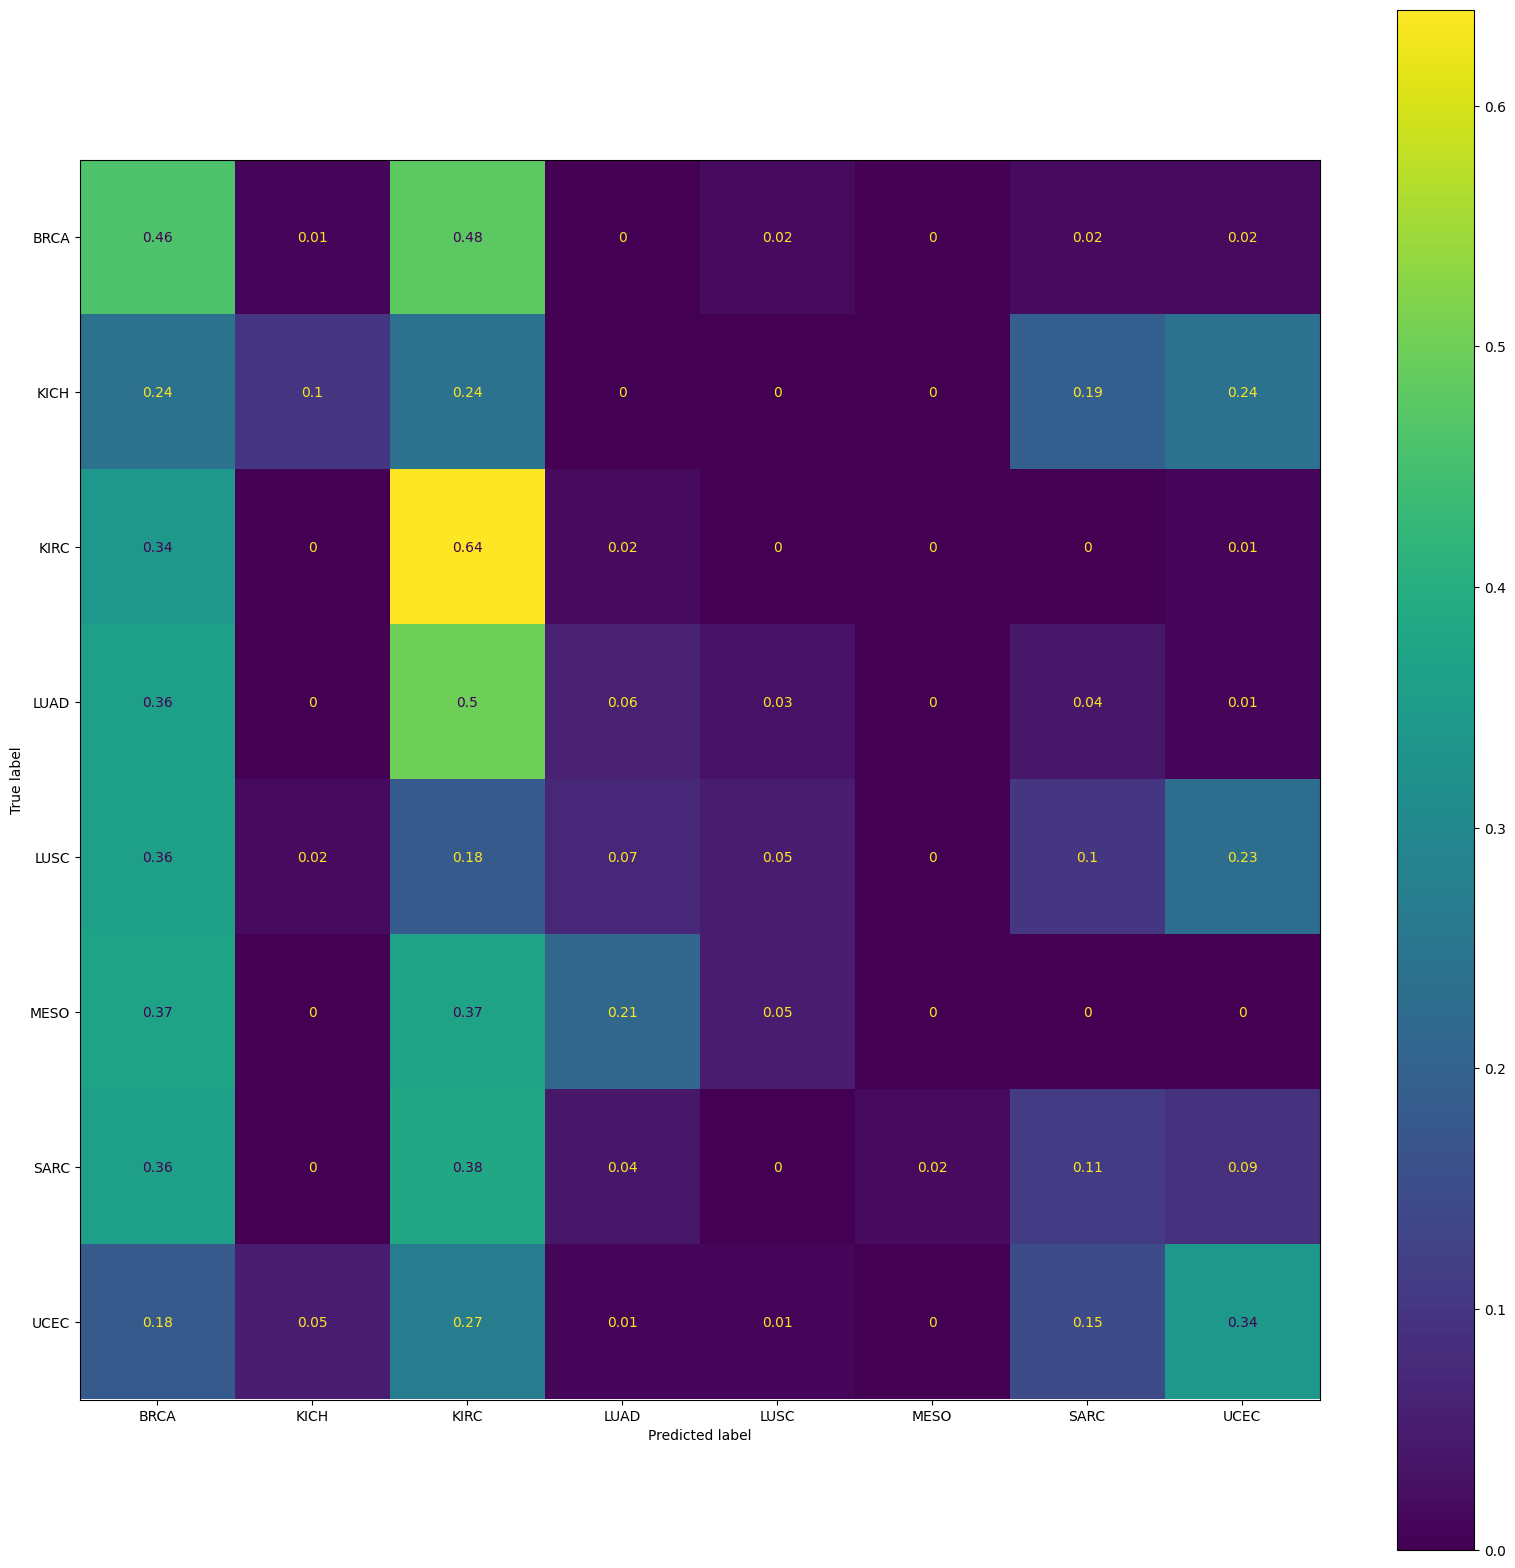

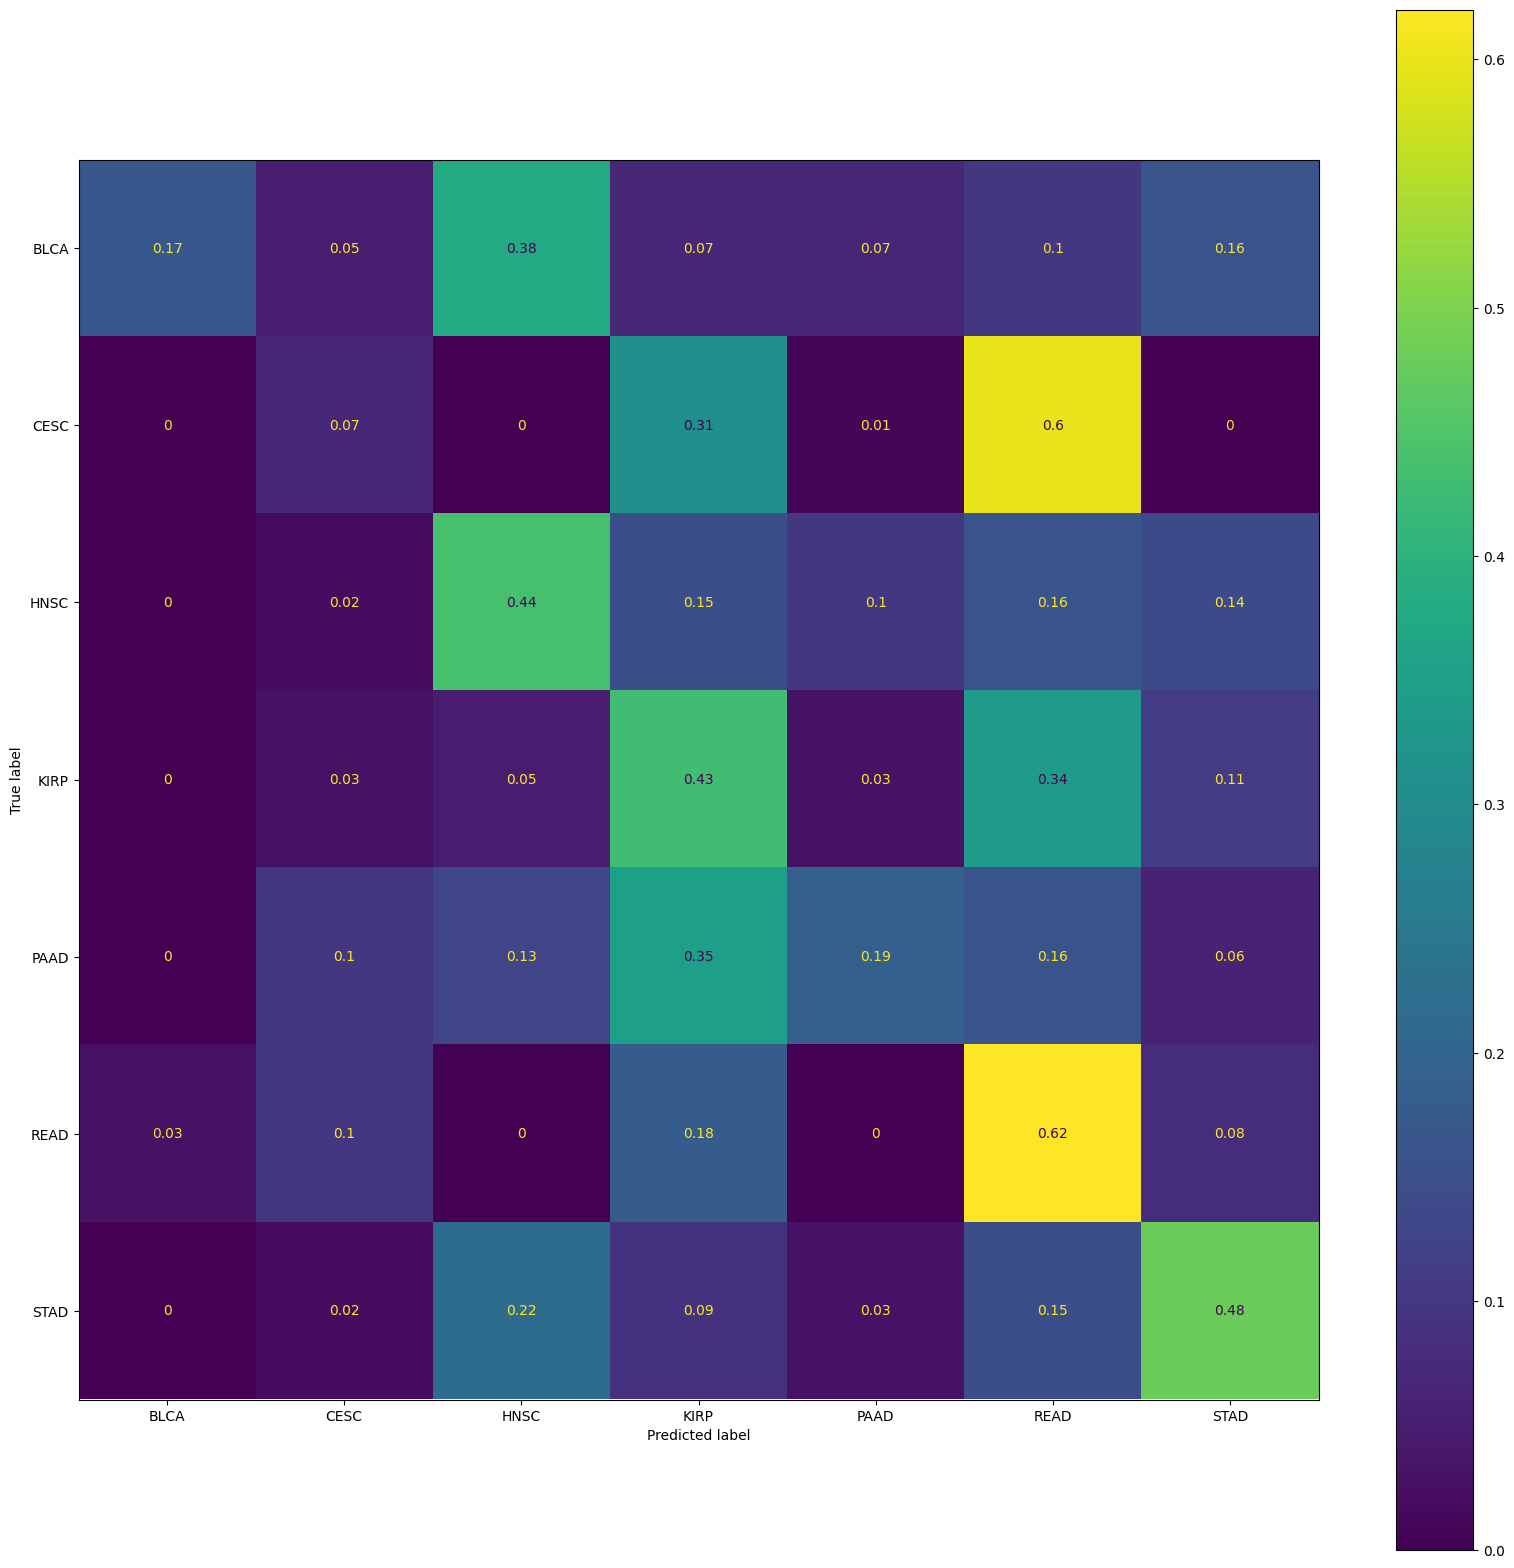

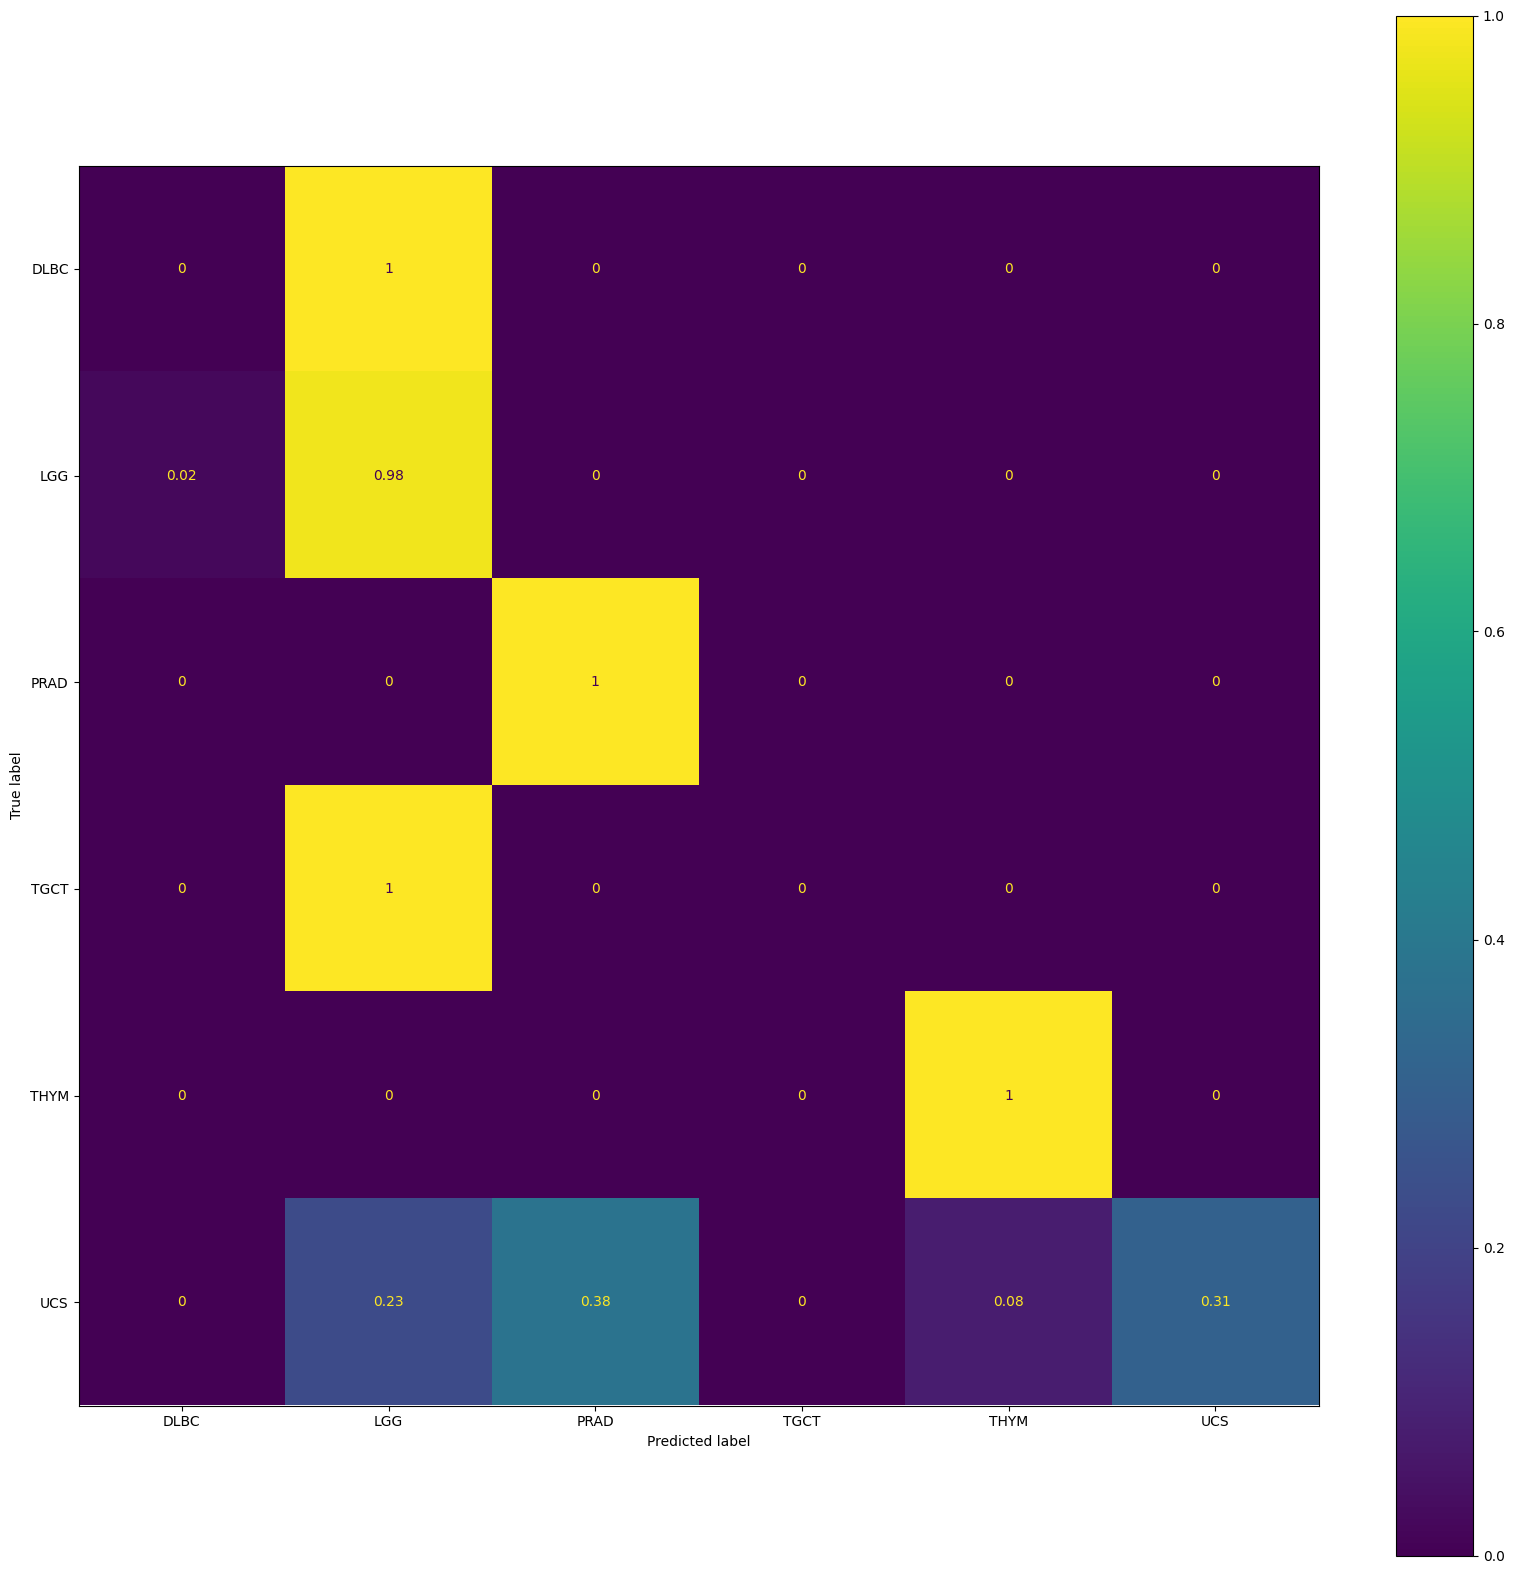

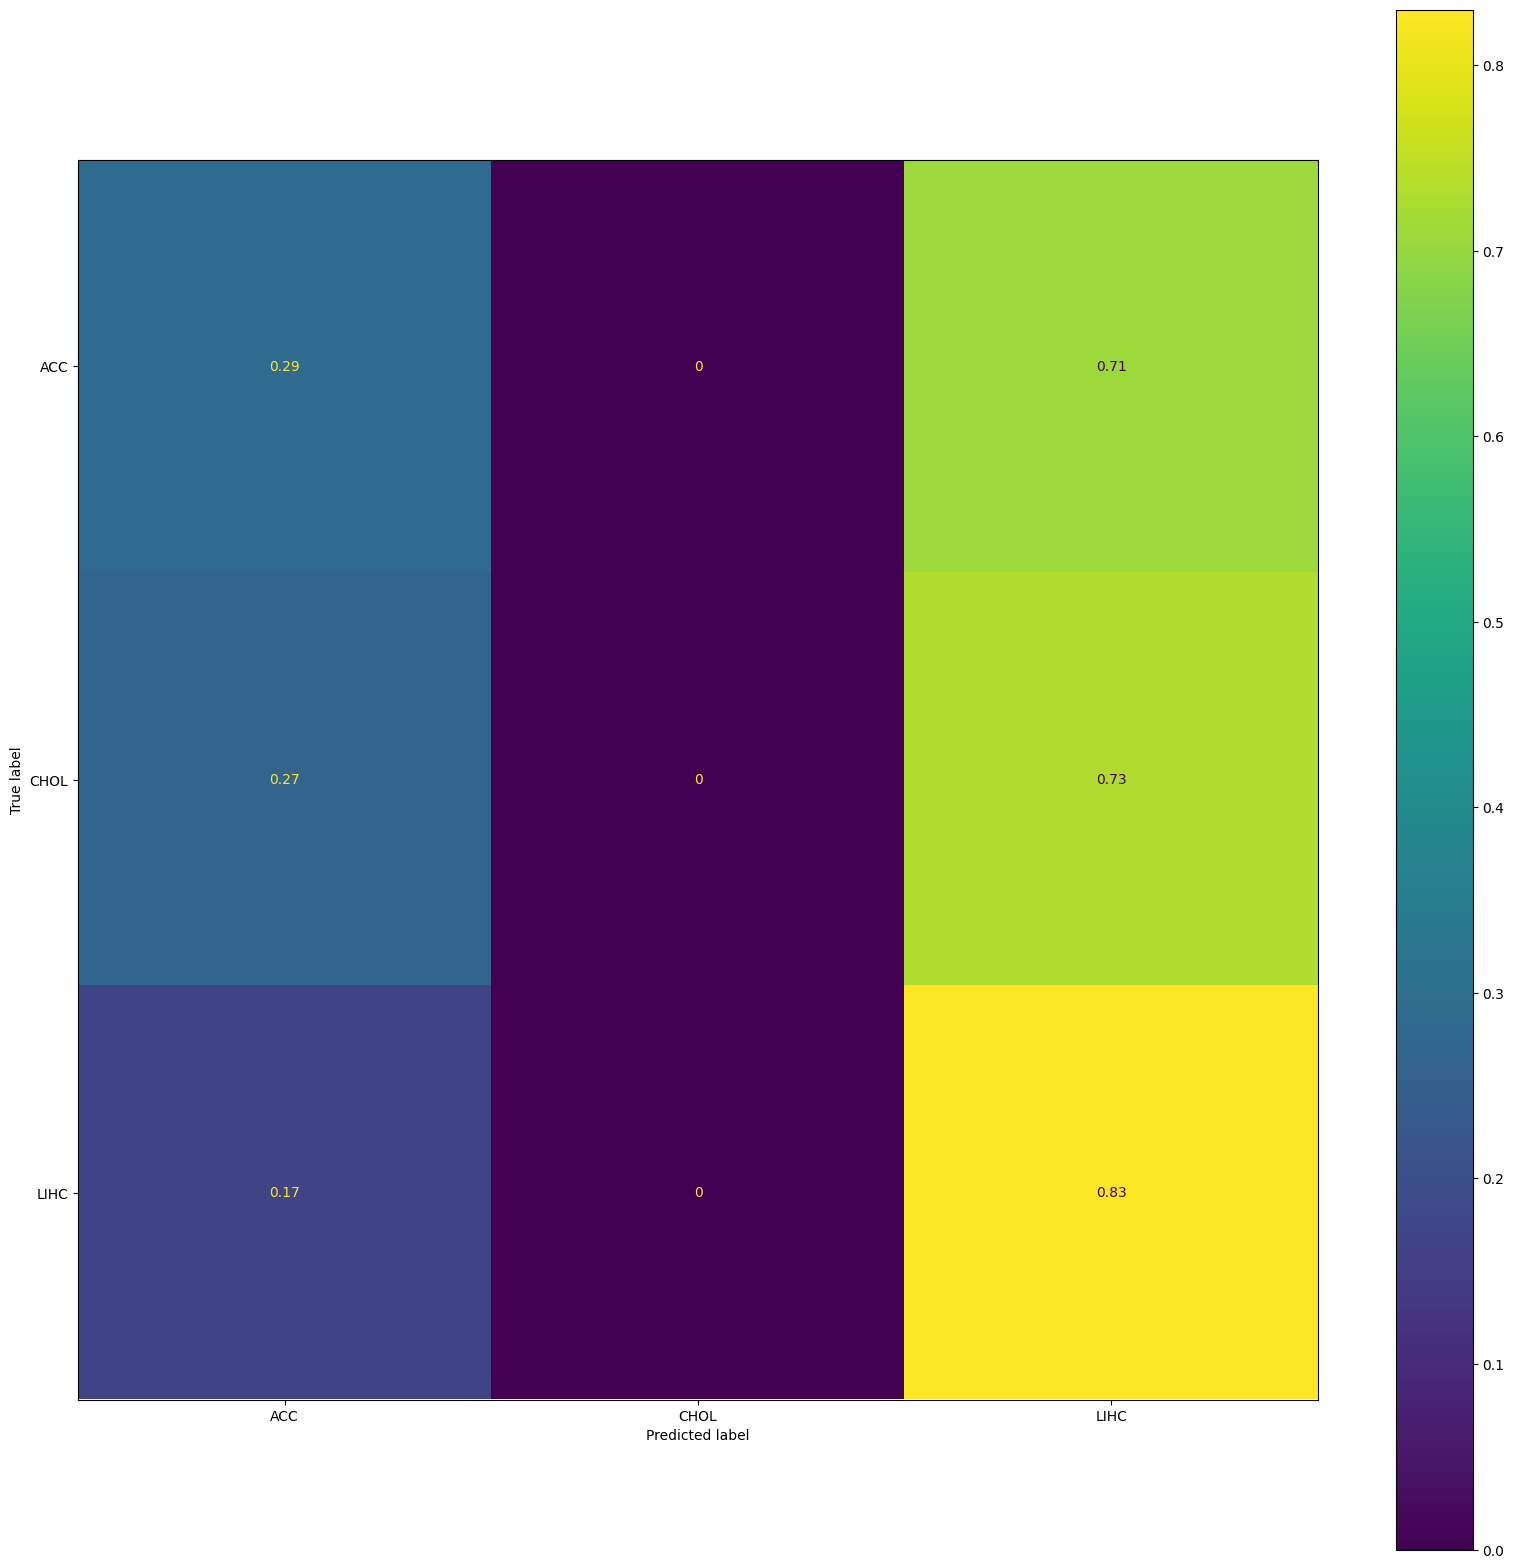

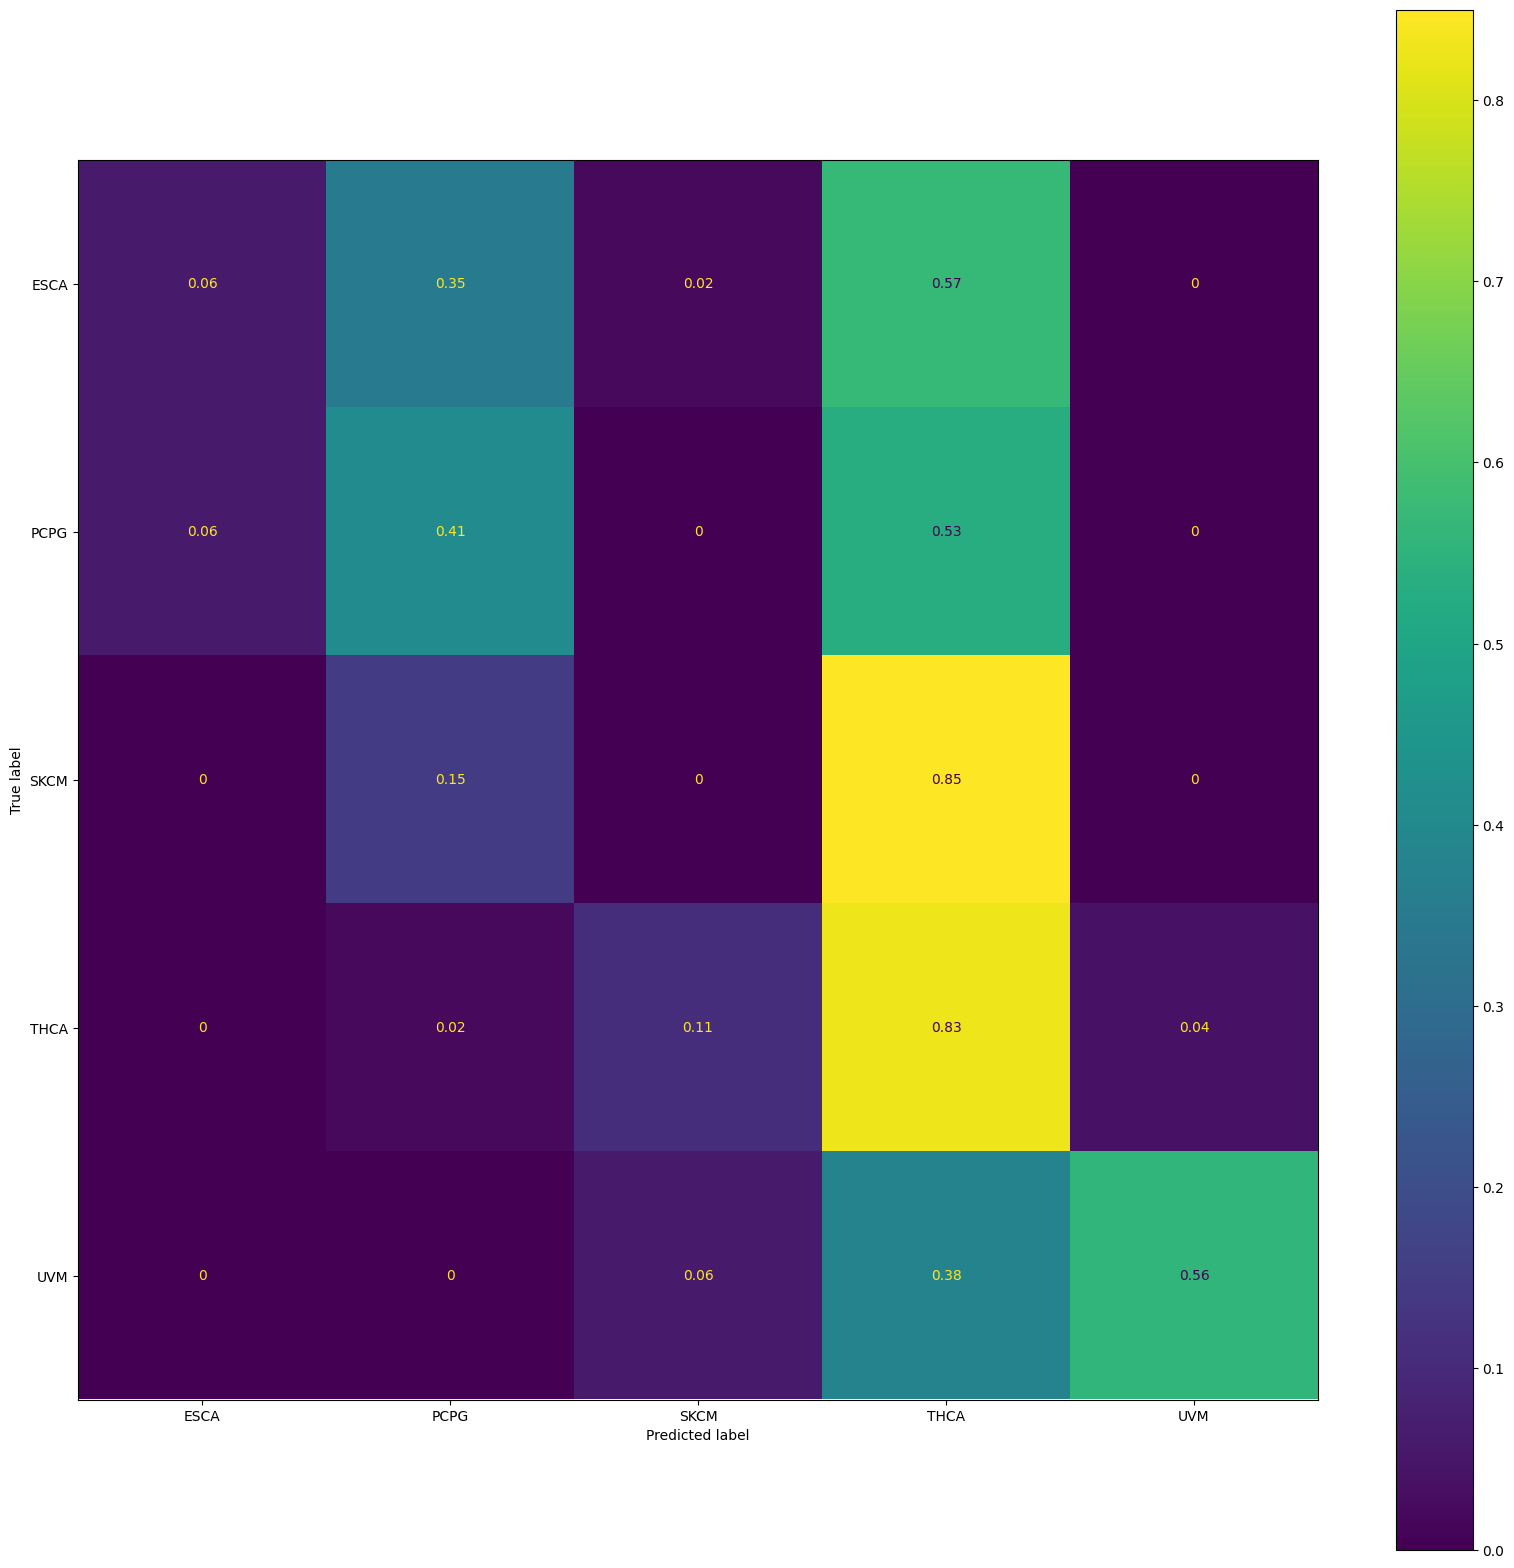

In [75]:
from src.utils.statistics import plot_confusion_matrix
#For each superclass, we load the model and we test it on the corresponding dataset
for i in range(len(superclasses)):
    params = load_params(model_name, i)
    test_dataloader = torch.utils.data.DataLoader(datasets_per_superclass[i], batch_size=128, shuffle=True)
    model = load_model(os.path.join('models', model_name), model_name, i, len(superclasses[i]), params, test_dataloader)
    if model_name.startswith('cnn'):
        accuracy = test(test_dataloader, model, loss_fn)
    else:
        accuracy = test_accuracy(test_dataloader, model)
    print(f"Accuracy for superclass {i}: {accuracy}")
    
    # Get the predictions
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            predictions = model(X)
            _, predicted_labels = torch.max(predictions, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    show_matrix(y_true, y_pred, superclasses[i])
    

